In [1]:
import pandas as pd
df = pd.read_csv('train_data.csv')

In [2]:
df.head()

,Unnamed: 0,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,...,TEAM_ID_opp,W_PCT_opp,PTS_RANK_opp,AST_RANK_opp,REB_RANK_opp,W_PCT_diff,PTS_RANK_diff,AST_RANK_diff,REB_RANK_diff,PTS_AWAY
0,0,22024,1610612738,BOS,Boston Celtics,22400061,2024-10-22,BOS vs. NYK,W,240,...,1610612752,0.610,19,29,5,0.170,-17,-15,-3,109
1,1,22024,1610612747,LAL,Los Angeles Lakers,22400062,2024-10-22,LAL vs. MIN,W,240,...,1610612750,0.683,18,15,15,-0.110,-12,-10,3,103
2,2,22024,1610612750,MIN,Minnesota Timberwolves,22400062,2024-10-22,MIN @ LAL,L,240,...,1610612747,0.573,6,5,18,0.110,12,10,-3,110
3,3,22024,1610612752,NYK,New York Knicks,22400061,2024-10-22,NYK @ BOS,L,240,...,1610612738,0.780,2,14,2,-0.170,17,15,3,132
4,4,22024,1610612737,ATL,Atlanta Hawks,22400064,2024-10-23,ATL vs. BKN,W,240,...,1610612751,0.390,25,20,11,0.049,-20,-4,-5,116


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV # used to calibrate a classifier's predicted prob to see if it accurately reflects true likelihood
from sklearn.pipeline import Pipeline # chaining together preprocessing and the model into one object
from sklearn.preprocessing import StandardScaler # zeroes out the mean and scales to unit variance
from xgboost import XGBClassifier # gradient-boosted decision tree classifier that outputs probabilities
from sklearn.model_selection import TimeSeriesSplit, cross_val_score



features = ['W_PCT_diff', 'elo_diff', 'momentum_5']
diff_columns = []
for i in features:
    diff_columns.append(f'{i}')

df_sorted = df.sort_values('GAME_DATE')
X = df_sorted[diff_columns] # independent variable
Y = df_sorted['WIN'] # dependent variable


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


###################################################################

# Time Series Split cross validation

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('xgb', XGBClassifier(
        objective= 'binary:logistic',
        n_estimators=250, # how mant trees are made / # of iterations
        max_depth=3, # how deep the tree is (max depth of each tree)
        learning_rate=0.01, #
        subsample=0.5, # % of how much of the training data is sampled (helps reduce overfitting)
        colsample_bytree=0.5, # % of features randomly sampled for each tree -> prevent any strong feature from dominating
        use_label_encoder=False, #checker for label encoding (made it false)
        eval_metric= 'logloss', # which metric to report during training/validation
        # logless essentially is a -1 * likelihood for binary classificiation, 
        # likelihood of probabilities when multiplied get really small over time
        # so a instead we take the log of the likelihood so that it is easier to keep track of
        # then multiply by -1 to maintain a common convention that lower scores are better
        reg_alpha= 2.0,
        reg_lambda= 5.0
    ))
])

time_series_split = TimeSeriesSplit(n_splits = 5) #trains the first 5 folds, starts testing with k+1 fold

model = CalibratedClassifierCV(
    estimator= pipe,
    cv = time_series_split,
    method = "sigmoid"
)

scores = cross_val_score(
    model, X, Y,
    cv = time_series_split,
    scoring= "roc_auc",
    n_jobs =- 1
)

print("TimeSeriesSplit CV AUC scores:", scores)
print("Mean CV AUC:", scores.mean())


model.fit(X_train, Y_train)
probs_test = model.predict_proba(X_test)[:,1]
prob_train = model.predict_proba(X_train)[:,1]
test_auc = roc_auc_score(Y_test, probs_test)
train_auc = roc_auc_score(Y_train, prob_train)


print(f"Test AUC: {test_auc:.3f}")
print(f"Train AUC: {train_auc:.3f}")






###################################################################

# xgboost classifier model

# X_cal, X_te, Y_cal, Y_te = train_test_split(X_test, Y_test, test_size=.5, random_state=50)

# pipe = Pipeline([
#     ('scale', StandardScaler()),
#     ('xgb', XGBClassifier(
#         objective= 'binary:logistic',
#         n_estimators=1000, # how mant trees are made / # of iterations
#         max_depth=5, # how deep the tree is (max depth of each tree)
#         learning_rate=0.01, #
#         subsample=0.9, # % of how much of the training data is sampled (helps reduce overfitting)
#         colsample_bytree=0.9, # % of features randomly sampled for each tree -> prevent any strong feature from dominating
#         use_label_encoder=False, #checker for lable encoding (made it false)
#         eval_metric= 'logloss', # which metric to report during training/validation
#         # logless essentially is a -1 * likelihood for binary classificiation, 
#         # likelihood of probabilities when multiplied get really small over time
#         # so a instead we take the log of the likelihood so that it is easier to keep track of
#         # then multiply by -1 to maintain a common convention that lower scores are better
#     ))
# ])

# pipe.fit(X_train, Y_train)

# model = CalibratedClassifierCV(pipe, cv='prefit', method='sigmoid')
# model.fit(X_cal, Y_cal)
# # cv=3 means that it specifies a 3-fold split of training data for calibration
# # isotonic calibration method helps with large set within your folds, while sigmoid is more when the set is smaller


# model.fit(X_train, Y_train)
# probs = model.predict_proba(X_test)[:,1]
# print("Test AUC: ", roc_auc_score(Y_test, probs))








###################################################################

# # linear regression model
# model = LogisticRegression(max_iter=1000)
# model.fit(X_train, Y_train)
# probs = model.predict_proba(X_test)[:,1]
# # this will return 2 columns
# # first column being the P(class=0), prob the team loses
# # second column being the P(class=1), prob that the team wins
# # the [:,1] takes the team wins probability and makes it into a 1D array

# print("AUC:", roc_auc_score(Y_test, probs)) # Area under the curve score

/Users/sohil/Documents/GitHub/NBA-Prediction-Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sohil/Documents/GitHub/NBA-Prediction-Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sohil/Documents/GitHub/NBA-Prediction-Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sohil/Documents/GitHub/NBA-Prediction-Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: User

TimeSeriesSplit CV AUC scores: [0.72117682 0.68565455 0.71522444 0.71831662 0.76541432]
Mean CV AUC: 0.7211573503722516


/Users/sohil/Documents/GitHub/NBA-Prediction-Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sohil/Documents/GitHub/NBA-Prediction-Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sohil/Documents/GitHub/NBA-Prediction-Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:05:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sohil/Documents/GitHub/NBA-Prediction-Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: User

Test AUC: 0.715
Train AUC: 0.730


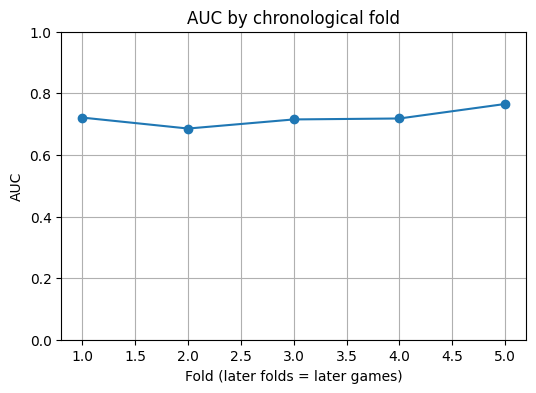

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(range(1, len(scores)+1), scores, marker='o')
plt.title('AUC by chronological fold')
plt.xlabel('Fold (later folds = later games)')
plt.ylabel('AUC')
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.show()

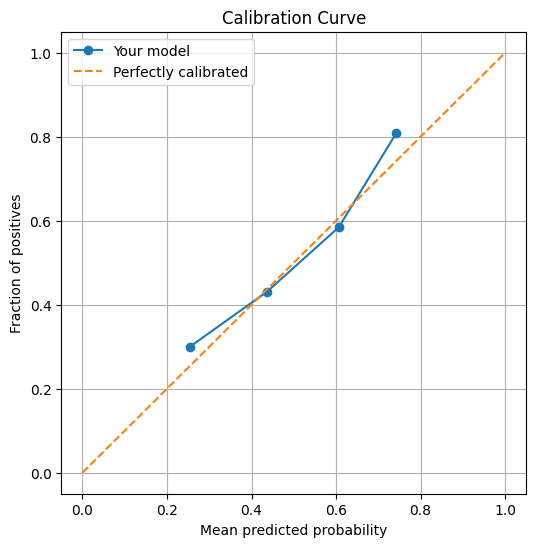

In [8]:


from sklearn.calibration import calibration_curve
frac_pos, mean_pred = calibration_curve(
    Y_test,
    probs_test, # use probs for the KFOLD prediction
    n_bins=4,
    strategy='quantile'
)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(mean_pred, frac_pos, marker='o', label='Your model')
plt.plot([0,1], [0,1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import numpy as np
from sklearn.calibration import calibration_curve

# get curve values (drops empty bins)
n_bins  = 6
frac_pos, mean_pred = calibration_curve(
    Y_test, probs_test,
    n_bins=n_bins,
    strategy="quantile"        # or "uniform"
)

strategy = "quantile"
# rebuild identical bin edges
if strategy == "uniform":
    bin_edges = np.linspace(0, 1, n_bins + 1)
else:                           # quantile
    bin_edges = np.quantile(probs_test, np.linspace(0, 1, n_bins + 1))
    bin_edges[0], bin_edges[-1] = 0.0, 1.0          # force exact 0‑1 ends

# count samples per bin
counts, _ = np.histogram(probs_test, bins=bin_edges)

# keep only the non‑empty bins (same ones calibration_curve kept)
nonempty  = counts > 0
counts_ne = counts[nonempty]

# now everything has the same length
ECE = np.sum(
    np.abs(frac_pos - mean_pred) * counts_ne / counts_ne.sum()
)
print(f"Expected calibration error: {ECE:.4f}")


Expected calibration error: 0.0223


/Users/sohil/Documents/GitHub/NBA-Prediction-Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:06:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sohil/Documents/GitHub/NBA-Prediction-Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:06:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sohil/Documents/GitHub/NBA-Prediction-Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:06:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sohil/Documents/GitHub/NBA-Prediction-Model/.venv/lib/python3.12/site-packages/xgboost/training.py:183: User

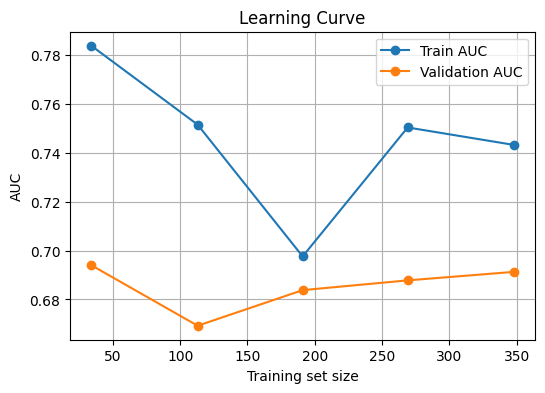

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, TimeSeriesSplit

N = X_train.shape[0]

train_size = [100, 200, 400, 800, N]
train_sizes, train_scores, val_scores = learning_curve(
    estimator=model,
    X=X_train, y=Y_train,
    cv=time_series_split,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1,1.0,5),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, 'o-', label='Train AUC')
plt.plot(train_sizes, val_mean,   'o-', label='Validation AUC')
plt.xlabel('Training set size')
plt.ylabel('AUC')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from joblib import dump

In [12]:
dump(model, 'moneyline_model.joblib')

['moneyline_model.joblib']